### Step 1: Load data

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
from ChestXRayDataset import ChestXRayDataset
from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import classification_report, precision_recall_curve
from tqdm import tqdm
import torch_optimizer as optim_mod
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
df_train = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_train.csv')
df_val = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_val.csv')
df_test = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_test.csv')

In [3]:
df_train.shape, df_val.shape, df_test.shape

((78506, 22), (12533, 22), (21081, 22))

Some images exist in images folder, but not in miccai labels and opposite

To fix this problem We create list of all image IDs in both train and test _images folder
then ensure that only images withing this list are loaded to dataset

In [4]:
image_dir_train = '../data/train_images'
image_dir_test = '../data/test_images'
# Define function to get valid image ids that exist in the image directory
def get_valid_image_ids(df, image_dir):
    # Get the set of image IDs that exist in the image directory
    image_files = set(os.listdir(image_dir))  # List of all files in the image directory
    # Check if image id exists in the image directory
    valid_ids = df[df['id'].isin(image_files)]['id']
    return valid_ids

In [5]:
# Get valid image ids for train and test datasets
valid_train_ids = get_valid_image_ids(df_train, image_dir_train)
valid_val_ids = get_valid_image_ids(df_val, image_dir_train)
valid_test_ids = get_valid_image_ids(df_test, image_dir_test)

In [6]:
# Filter the DataFrames to include only the valid image IDs
df_train_valid = df_train[df_train['id'].isin(valid_train_ids)]
df_val_valid = df_val[df_val['id'].isin(valid_val_ids)]
df_test_valid = df_test[df_test['id'].isin(valid_test_ids)]

df_train_valid.shape, df_val_valid.shape, df_test_valid.shape

((78506, 22), (8018, 22), (21081, 22))

In [7]:
df_train_val = pd.concat([df_train_valid, df_val_valid], ignore_index=True)
assert df_train_val.shape[0] == df_train_valid.shape[0] + df_val_valid.shape[0]

In [8]:
df_train_val = df_train_val.copy()
#df_train_val.drop(columns=['Pneumomediastinum', 'subj_id'], inplace=True)
# Labels such Pneumomediastinum and Hernia rarely appears, but we keep them to generlize the model
df_train_val.drop(columns=['subj_id'], inplace=True)
df_train_val.shape

(86524, 21)

In [9]:
## Do same for testing
df_test_valid = df_test_valid.copy()
df_test_valid.drop(columns=['subj_id'], inplace=True)
df_test_valid.shape

(21081, 21)

### Step 2: Label encoding and create target column 

#### Step 2.1: Check for Inconsistent Rows

First, we’ll check if any rows violate the condition: if No Finding is 1, then all other categories should be 0.

In [10]:
# For train data
inconsistent_rows = df_train_val[(df_train_val['No Finding'] == 1) & (df_train_val.iloc[:, 1:-1].sum(axis=1) > 0)]

print(inconsistent_rows)

Empty DataFrame
Columns: [id, Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, Nodule, Pleural Thickening, Pneumonia, Pneumothorax, Pneumoperitoneum, Pneumomediastinum, Subcutaneous Emphysema, Tortuous Aorta, Calcification of the Aorta, No Finding]
Index: []

[0 rows x 21 columns]


#### Step 2.2: create mappings variable for all categories we have

In [11]:
# Extract all categories (exclude 'id')
categories = df_train_val.columns[1:]

# Create a mapping dictionary for categories to numbers
category_mapping = {category: idx for idx, category in enumerate(categories)}

print("Category Mapping:")
print(category_mapping)

Category Mapping:
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'Nodule': 10, 'Pleural Thickening': 11, 'Pneumonia': 12, 'Pneumothorax': 13, 'Pneumoperitoneum': 14, 'Pneumomediastinum': 15, 'Subcutaneous Emphysema': 16, 'Tortuous Aorta': 17, 'Calcification of the Aorta': 18, 'No Finding': 19}


### Step 2.3: Create finding column

This column will contain list of all finding categories for each image, and we have the following scenarios
1. The image has no sickness ==> finding column is a list with only one item 'No Finding'
2. The image contains only one category i.g 'Hernia' ==> finding column is a list with only one item 'Hernia'
3. The image contains more than one category i.g 'Hernia' and 'Edema'...etc. ==> finding column is a list finding items 'Hernia' and 'Edema'

In [12]:
# Function to create 'finding' and 'finding_encoded' as a string based on category values
def create_finding(row):
    # Check if 'No Finding' is 1, indicating no other categories are marked
    if row['No Finding'] == 1:
        return ['No Finding'], str(category_mapping['No Finding'])  # Return encoded as a string
    
    else:
        # Generate lists of findings and their encoded values
        findings = [category for category in categories if row[category] == 1]
        encoded_findings = [str(category_mapping[category]) for category in findings]
        
        # Join encoded findings as a single string for stratification
        return findings, ','.join(encoded_findings)


In [13]:
# Apply function to create 'finding' and 'finding_encoded' columns in train_val data
df_train_val[['finding', 'finding_encoded']] = df_train_val.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_train_val[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000001_000.png,[Cardiomegaly],1
1,00000001_001.png,"[Cardiomegaly, Emphysema]","1,5"
2,00000001_002.png,"[Cardiomegaly, Effusion]","1,4"
3,00000002_000.png,[No Finding],19
4,00000004_000.png,"[Mass, Nodule]","9,10"
...,...,...,...
86519,00030601_000.png,[Atelectasis],0
86520,00030661_000.png,[Atelectasis],0
86521,00030703_000.png,[Nodule],10
86522,00030703_001.png,[Nodule],10


In [14]:
# Apply function to create 'finding' and 'finding_encoded' columns in test data
df_test_valid[['finding', 'finding_encoded']] = df_test_valid.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_test_valid[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000013_000.png,[No Finding],19
1,00000013_001.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","5,13,16"
2,00000013_002.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","5,13,16"
3,00000013_003.png,[Pleural Thickening],11
4,00000013_004.png,"[Effusion, Emphysema, Infiltration, Pneumothor...","4,5,8,13,16"
...,...,...,...
21076,00030800_000.png,[No Finding],19
21077,00030802_000.png,[No Finding],19
21078,00030803_000.png,[No Finding],19
21079,00030804_000.png,[No Finding],19


In [15]:
class_counts_train = df_train_val.sum(axis=0)
class_counts_train

id                            00000001_000.png00000001_001.png00000001_002.p...
Atelectasis                                                                8280
Cardiomegaly                                                               1707
Consolidation                                                              2852
Edema                                                                      1378
Effusion                                                                   8659
Emphysema                                                                  1423
Fibrosis                                                                   1251
Hernia                                                                      141
Infiltration                                                              13782
Mass                                                                       4034
Nodule                                                                     4708
Pleural Thickening                      

In [16]:
class_counts_test = df_test_valid.sum(axis=0)
class_counts_test

id                            00000013_000.png00000013_001.png00000013_002.p...
Atelectasis                                                                2700
Cardiomegaly                                                                868
Consolidation                                                              1497
Edema                                                                       751
Effusion                                                                   3735
Emphysema                                                                   917
Fibrosis                                                                    365
Hernia                                                                       62
Infiltration                                                               5159
Mass                                                                       1329
Nodule                                                                     1305
Pleural Thickening                      

### Step 3: Create subsets and DataLoaders for the training, validation, and test sets

In [17]:
# Image transformation for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
subset_ratio = 0.99 # start with 30% of data
train_val_ratio = 0.8 # For train, val ratio

#### Step 3.1 Take a Stratified Subset Based on finding_encoded

**First: create the subset**

In [19]:
label_matrix = df_train_val['finding_encoded'].str.get_dummies(sep=',')

# Initialize IterativeStratification
stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[subset_ratio, 1 - subset_ratio]) # 1 - 0.3 = 0.7

# Perform the stratified split
train_indices, subset_indices = next(stratifier.split(df_train_val, label_matrix))

# Create the subset and remaining dataframes
subset_df_train_val = df_train_val.iloc[subset_indices].reset_index(drop=True)
remaining_df_train_val = df_train_val.iloc[train_indices].reset_index(drop=True)

In [20]:
# After the first stratified split (Subset and Remaining)
initial_size = len(df_train_val)
print(f"Initial size of df_train_val: {initial_size} rows")

subset_size = len(subset_df_train_val)
remaining_size = len(remaining_df_train_val)
print(f"Subset size for training (80%): {subset_size} rows")
print(f"Remaining size not used (20%): {remaining_size} rows")

Initial size of df_train_val: 86524 rows
Subset size for training (80%): 85643 rows
Remaining size not used (20%): 881 rows


In [21]:
assert initial_size == subset_size + remaining_size

In [22]:
subset_df_train_val.shape

(85643, 23)

**Then: split to train, val**

In [23]:
# Perform the stratified split
label_matrix_2 = subset_df_train_val['finding_encoded'].str.get_dummies(sep=',')
stratifier_2 = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[train_val_ratio, 1 - train_val_ratio]) 
val_indices, train_indices = next(stratifier_2.split(subset_df_train_val, label_matrix_2))

train_df = subset_df_train_val.iloc[train_indices].reset_index(drop=True)
val_df = subset_df_train_val.iloc[val_indices].reset_index(drop=True)

# Verify the sizes
print(f"Train size (80% of subset): {len(train_df)} rows")
print(f"Val size (20% of subset): {len(val_df)} rows")

Train size (80% of subset): 68442 rows
Val size (20% of subset): 17201 rows


#### Step 3.2: Create dataset objects


In [24]:
train_dataset = ChestXRayDataset(dataframe=train_df, image_dir=image_dir_train, category_mapping=category_mapping, transform=train_transform)

val_dataset = ChestXRayDataset(dataframe=val_df, image_dir=image_dir_train, category_mapping=category_mapping, transform=val_transform)

test_dataset = ChestXRayDataset(dataframe=df_test_valid, image_dir=image_dir_test, category_mapping=category_mapping, transform=val_transform)

#### Step 3.3: Create dataloaders

In [25]:
# Create Dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [26]:
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Testing DataLoader: {len(test_loader)} batches")

Training DataLoader: 2139 batches
Validation DataLoader: 538 batches
Testing DataLoader: 659 batches


### Step 4: Define the model
We use pretrained ResNet

- We add linear layer to predict multi-label ( more than one category per image)
- ResNet-50 designed to output 2048 features
- We add two Linear layer to avoid going down from 2048 features to only 20 which may cause instability and overfitting

**Note**: as first step we do not add any additional params/functionality to the network i.g Dropout, normal...etc

In [28]:
# Number of unique categories (labels) in the 'finding_encoded' column
num_classes = len(df_train_val['finding_encoded'].str.get_dummies(sep=',').columns)
print(num_classes)

20


In [29]:
model = models.resnet50(weights='IMAGENET1K_V2') 
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # to reduce complexity gradually (2048, 512)
    nn.BatchNorm1d(512),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(512, 256), 
    nn.BatchNorm1d(256),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),  # Exclude 'id', 20 different categories
    nn.Sigmoid()  # Sigmoid for multi-label classification
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Step 5: Train, Validate and test the model

[Referance about BCEWithLogitsLoss()](https://medium.com/@sahilcarterr/why-nn-bcewithlogitsloss-numerically-stable-6a04f3052967)

nn.BCEWithLogitsLoss():

1. This loss function is more efficient because it combines the sigmoid activation and binary cross-entropy loss into a single function.
2. It expects the raw logits (not passed through sigmoid) as input and applies the sigmoid internally.
3. It's numerically more stable and faster than using nn.BCELoss() with a separate sigmoid.

nn.BCELoss():

1. This loss function expects the model's output to be probabilities in the range [0, 1], so it requires you to apply a sigmoid activation to the model's output beforehand.
2. The formula for binary cross-entropy is applied after transforming the raw logits into probabilities using the sigmoid function.

In [30]:
# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss()  # Combined Sigmoid + Binary Cross-Entropy Loss

In [31]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7) 

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
lookahead_optimizer = optim_mod.Lookahead(optimizer, k=5, alpha=0.5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)

In [33]:
# Initialize lists to store loss and accuracy per epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

threshold = 0.5

In [34]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels, _ in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Calculate F1 scores and thresholds for each class
    best_thresholds = []
    for i in range(all_labels.shape[1]):
        precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_threshold)

    # Apply class-specific thresholds
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    correct_predictions = (thresholded_preds == all_labels).all(axis=1).sum()
    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / all_labels.shape[0]) * 100

    report = classification_report(all_labels, thresholded_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    return avg_loss, avg_accuracy, precision, recall, f1, best_thresholds, correct_predictions


In [35]:
def validate(model, dataloader, criterion, device, best_thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Apply class-specific thresholds
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    correct_predictions = (thresholded_preds == all_labels).all(axis=1).sum()
    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / all_labels.shape[0]) * 100

    report = classification_report(all_labels, thresholded_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    return avg_loss, avg_accuracy, precision, recall, f1, correct_predictions

In [36]:
def test(model, dataloader, criterion, device, label_names, best_thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    print("\nFinding Best Thresholds for Each Class (Reported Only):")
    for i, threshold in enumerate(best_thresholds):
        print(f"Class '{label_names[i]}': Best Threshold = {threshold:.4f}")

    default_preds = (all_preds > 0.5).astype(float)

    print("\nClassification Report with Best Thresholds:")
    report_best = classification_report(all_labels, thresholded_preds, target_names=label_names, zero_division=0)
    print(report_best)

    print("\nClassification Report with Default Threshold (0.5):")
    report_default = classification_report(all_labels, default_preds, target_names=label_names, zero_division=0)
    print(report_default)

    avg_loss = running_loss / len(dataloader)

    return avg_loss, report_best, report_default, best_thresholds

In [37]:
num_epochs = 100

# Early stopping parameters
patience = 8 # wait for two epochs
best_val = float("inf")
epochs_no_improve = 0

# for plotting
num_epochs_runned = 0

In [38]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Train the model for one epoch
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_best_threshold, train_correct_predictions = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
      f"Train F1: {train_f1:.4f}, Train Best Threshold: {train_best_threshold:.4f}, "
      f"Train correct predictions: {train_correct_predictions}")



    # Validate the model after training
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_correct_predictions = validate(model, val_loader, criterion, device, train_best_threshold)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
      f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, "
      f"Val F1: {val_f1:.4f}, Val correct predictions: {val_correct_predictions}")


    # Step the Lookahead optimizer
    lookahead_optimizer.step()
    # Step the ReduceLROnPlateau scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}: Learning rate = {scheduler.get_last_lr()[0]}")

    num_epochs_runned += 1

    # Validation loss has improved
    if val_loss < best_val:
        best_val = val_loss
        epochs_no_improve = 0  # Reset the counter if we see improvement
        
        # Save the model checkpoint
        torch.save(model.state_dict(), "basic_model.pth")
        print("Model improved and saved.")
    else:
        print("Model did not improved")
        epochs_no_improve += 1  # Increment counter if no improvement

    # Early stopping
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break

    print("-" * 100)

Epoch [1/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.75it/s]


Train Loss: 0.6933, Train Accuracy: 42.3366, Train Precision: 0.0651, Train Recall: 0.0550, Train F1: 0.0520, Train Best Threshold: 0.5095, Train correct predictions: 28976


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.45it/s]


Val Loss: 0.6914, Val Accuracy: 45.5613, Val Precision: 0.0314, Val Recall: 0.0398, Val F1: 0.0351, Val correct predictions: 7837
Epoch 1: Learning rate = 0.001
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [2/100]


Training: 100%|██████████| 2139/2139 [05:14<00:00,  6.79it/s]


Train Loss: 0.6910, Train Accuracy: 53.7243, Train Precision: 0.0619, Train Recall: 0.0472, Train F1: 0.0374, Train Best Threshold: 0.5002, Train correct predictions: 36770


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.47it/s]


Val Loss: 0.6905, Val Accuracy: 55.3107, Val Precision: 0.0296, Val Recall: 0.0483, Val F1: 0.0367, Val correct predictions: 9514
Epoch 2: Learning rate = 0.001
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [3/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.79it/s]


Train Loss: 0.6906, Train Accuracy: 52.4429, Train Precision: 0.0704, Train Recall: 0.0460, Train F1: 0.0377, Train Best Threshold: 0.5001, Train correct predictions: 35893


Validating: 100%|██████████| 538/538 [01:25<00:00,  6.33it/s]


Val Loss: 0.6913, Val Accuracy: 56.0723, Val Precision: 0.0712, Val Recall: 0.0497, Val F1: 0.0381, Val correct predictions: 9645
Epoch 3: Learning rate = 0.001
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [4/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.77it/s]


Train Loss: 0.6904, Train Accuracy: 50.9906, Train Precision: 0.0564, Train Recall: 0.0449, Train F1: 0.0379, Train Best Threshold: 0.5001, Train correct predictions: 34899


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.45it/s]


Val Loss: 0.6919, Val Accuracy: 29.3413, Val Precision: 0.0375, Val Recall: 0.0256, Val F1: 0.0304, Val correct predictions: 5047
Epoch 4: Learning rate = 0.001
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [5/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.75it/s]


Train Loss: 0.6903, Train Accuracy: 49.6873, Train Precision: 0.0637, Train Recall: 0.0435, Train F1: 0.0375, Train Best Threshold: 0.5001, Train correct predictions: 34007


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.48it/s]


Val Loss: 0.6903, Val Accuracy: 46.7705, Val Precision: 0.0637, Val Recall: 0.0410, Val F1: 0.0372, Val correct predictions: 8045
Epoch 5: Learning rate = 0.001
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [6/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6902, Train Accuracy: 49.3279, Train Precision: 0.0524, Train Recall: 0.0431, Train F1: 0.0374, Train Best Threshold: 0.5000, Train correct predictions: 33761


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.48it/s]


Val Loss: 0.6901, Val Accuracy: 50.6366, Val Precision: 0.0794, Val Recall: 0.0447, Val F1: 0.0382, Val correct predictions: 8710
Epoch 6: Learning rate = 0.001
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [7/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.76it/s]


Train Loss: 0.6905, Train Accuracy: 52.0061, Train Precision: 0.0590, Train Recall: 0.0458, Train F1: 0.0380, Train Best Threshold: 0.5000, Train correct predictions: 35594


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.45it/s]


Val Loss: 0.6909, Val Accuracy: 55.3049, Val Precision: 0.0299, Val Recall: 0.0483, Val F1: 0.0369, Val correct predictions: 9513
Epoch 7: Learning rate = 0.001
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [8/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6903, Train Accuracy: 51.5838, Train Precision: 0.0475, Train Recall: 0.0456, Train F1: 0.0382, Train Best Threshold: 0.5000, Train correct predictions: 35305


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.48it/s]


Val Loss: 0.6903, Val Accuracy: 48.6135, Val Precision: 0.0329, Val Recall: 0.0424, Val F1: 0.0371, Val correct predictions: 8362
Epoch 8: Learning rate = 0.001
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [9/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.77it/s]


Train Loss: 0.6902, Train Accuracy: 50.5304, Train Precision: 0.0476, Train Recall: 0.0441, Train F1: 0.0375, Train Best Threshold: 0.5000, Train correct predictions: 34584


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.46it/s]


Val Loss: 0.6901, Val Accuracy: 49.9041, Val Precision: 0.0322, Val Recall: 0.0436, Val F1: 0.0370, Val correct predictions: 8584
Epoch 9: Learning rate = 0.001
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [10/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6901, Train Accuracy: 50.0102, Train Precision: 0.0552, Train Recall: 0.0437, Train F1: 0.0377, Train Best Threshold: 0.5000, Train correct predictions: 34228


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.48it/s]


Val Loss: 0.6900, Val Accuracy: 49.6192, Val Precision: 0.0325, Val Recall: 0.0433, Val F1: 0.0371, Val correct predictions: 8535
Epoch 10: Learning rate = 0.001
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [11/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6900, Train Accuracy: 49.0824, Train Precision: 0.0703, Train Recall: 0.0429, Train F1: 0.0379, Train Best Threshold: 0.5000, Train correct predictions: 33593


Validating: 100%|██████████| 538/538 [01:24<00:00,  6.37it/s]


Val Loss: 0.6903, Val Accuracy: 51.4505, Val Precision: 0.0318, Val Recall: 0.0449, Val F1: 0.0372, Val correct predictions: 8850
Epoch 11: Learning rate = 0.001
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [12/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.77it/s]


Train Loss: 0.6901, Train Accuracy: 49.8597, Train Precision: 0.0583, Train Recall: 0.0437, Train F1: 0.0378, Train Best Threshold: 0.5000, Train correct predictions: 34125


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.43it/s]


Val Loss: 0.6901, Val Accuracy: 50.7994, Val Precision: 0.0321, Val Recall: 0.0444, Val F1: 0.0372, Val correct predictions: 8738
Epoch 12: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [13/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.77it/s]


Train Loss: 0.6900, Train Accuracy: 49.3966, Train Precision: 0.0620, Train Recall: 0.0435, Train F1: 0.0384, Train Best Threshold: 0.5000, Train correct predictions: 33808


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.42it/s]


Val Loss: 0.6901, Val Accuracy: 52.3400, Val Precision: 0.0316, Val Recall: 0.0457, Val F1: 0.0374, Val correct predictions: 9003
Epoch 13: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [14/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.77it/s]


Train Loss: 0.6899, Train Accuracy: 48.8501, Train Precision: 0.0666, Train Recall: 0.0437, Train F1: 0.0395, Train Best Threshold: 0.5000, Train correct predictions: 33434


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.46it/s]


Val Loss: 0.6900, Val Accuracy: 47.4158, Val Precision: 0.0338, Val Recall: 0.0414, Val F1: 0.0372, Val correct predictions: 8156
Epoch 14: Learning rate = 0.0007
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [15/100]


Training: 100%|██████████| 2139/2139 [05:14<00:00,  6.80it/s]


Train Loss: 0.6899, Train Accuracy: 48.4980, Train Precision: 0.0632, Train Recall: 0.0424, Train F1: 0.0378, Train Best Threshold: 0.5000, Train correct predictions: 33193


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.44it/s]


Val Loss: 0.6898, Val Accuracy: 48.9506, Val Precision: 0.0335, Val Recall: 0.0427, Val F1: 0.0376, Val correct predictions: 8420
Epoch 15: Learning rate = 0.0007
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [16/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6899, Train Accuracy: 48.5974, Train Precision: 0.0627, Train Recall: 0.0435, Train F1: 0.0394, Train Best Threshold: 0.5000, Train correct predictions: 33261


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.48it/s]


Val Loss: 0.6898, Val Accuracy: 47.4449, Val Precision: 0.0342, Val Recall: 0.0414, Val F1: 0.0375, Val correct predictions: 8161
Epoch 16: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [17/100]


Training: 100%|██████████| 2139/2139 [05:14<00:00,  6.80it/s]


Train Loss: 0.6899, Train Accuracy: 47.9472, Train Precision: 0.0659, Train Recall: 0.0425, Train F1: 0.0387, Train Best Threshold: 0.5000, Train correct predictions: 32816


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.48it/s]


Val Loss: 0.6898, Val Accuracy: 46.4450, Val Precision: 0.0342, Val Recall: 0.0406, Val F1: 0.0371, Val correct predictions: 7989
Epoch 17: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [18/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6899, Train Accuracy: 47.6681, Train Precision: 0.0577, Train Recall: 0.0420, Train F1: 0.0383, Train Best Threshold: 0.5000, Train correct predictions: 32625


Validating: 100%|██████████| 538/538 [01:22<00:00,  6.50it/s]


Val Loss: 0.6900, Val Accuracy: 50.2994, Val Precision: 0.0326, Val Recall: 0.0439, Val F1: 0.0374, Val correct predictions: 8652
Epoch 18: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [19/100]


Training: 100%|██████████| 2139/2139 [05:14<00:00,  6.81it/s]


Train Loss: 0.6898, Train Accuracy: 46.9346, Train Precision: 0.0673, Train Recall: 0.0414, Train F1: 0.0384, Train Best Threshold: 0.5000, Train correct predictions: 32123


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.46it/s]


Val Loss: 0.6899, Val Accuracy: 45.0148, Val Precision: 0.0344, Val Recall: 0.0393, Val F1: 0.0367, Val correct predictions: 7743
Epoch 19: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [20/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.75it/s]


Train Loss: 0.6898, Train Accuracy: 47.1187, Train Precision: 0.0618, Train Recall: 0.0411, Train F1: 0.0377, Train Best Threshold: 0.5000, Train correct predictions: 32249


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.44it/s]


Val Loss: 0.6897, Val Accuracy: 46.1136, Val Precision: 0.0346, Val Recall: 0.0403, Val F1: 0.0372, Val correct predictions: 7932
Epoch 20: Learning rate = 0.0007
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [21/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.77it/s]


Train Loss: 0.6897, Train Accuracy: 46.8908, Train Precision: 0.0647, Train Recall: 0.0412, Train F1: 0.0380, Train Best Threshold: 0.5000, Train correct predictions: 32093


Validating: 100%|██████████| 538/538 [01:22<00:00,  6.51it/s]


Val Loss: 0.6899, Val Accuracy: 48.6541, Val Precision: 0.0334, Val Recall: 0.0425, Val F1: 0.0374, Val correct predictions: 8369
Epoch 21: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [22/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.76it/s]


Train Loss: 0.6898, Train Accuracy: 47.2108, Train Precision: 0.0631, Train Recall: 0.0414, Train F1: 0.0381, Train Best Threshold: 0.5000, Train correct predictions: 32312


Validating: 100%|██████████| 538/538 [01:22<00:00,  6.49it/s]


Val Loss: 0.6901, Val Accuracy: 50.7936, Val Precision: 0.0325, Val Recall: 0.0444, Val F1: 0.0375, Val correct predictions: 8737
Epoch 22: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [23/100]


Training: 100%|██████████| 2139/2139 [05:19<00:00,  6.70it/s]


Train Loss: 0.6898, Train Accuracy: 47.1100, Train Precision: 0.0679, Train Recall: 0.0416, Train F1: 0.0386, Train Best Threshold: 0.5000, Train correct predictions: 32243


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.43it/s]


Val Loss: 0.6898, Val Accuracy: 45.7415, Val Precision: 0.0347, Val Recall: 0.0399, Val F1: 0.0371, Val correct predictions: 7868
Epoch 23: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [24/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6898, Train Accuracy: 47.1932, Train Precision: 0.0609, Train Recall: 0.0417, Train F1: 0.0386, Train Best Threshold: 0.5000, Train correct predictions: 32300


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.44it/s]


Val Loss: 0.6898, Val Accuracy: 47.7763, Val Precision: 0.0341, Val Recall: 0.0417, Val F1: 0.0375, Val correct predictions: 8218
Epoch 24: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [25/100]


Training: 100%|██████████| 2139/2139 [05:17<00:00,  6.73it/s]


Train Loss: 0.6897, Train Accuracy: 47.4183, Train Precision: 0.0519, Train Recall: 0.0414, Train F1: 0.0379, Train Best Threshold: 0.5000, Train correct predictions: 32454


Validating: 100%|██████████| 538/538 [01:24<00:00,  6.37it/s]


Val Loss: 0.6900, Val Accuracy: 43.7823, Val Precision: 0.0351, Val Recall: 0.0382, Val F1: 0.0366, Val correct predictions: 7531
Epoch 25: Learning rate = 0.0007
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [26/100]


Training: 100%|██████████| 2139/2139 [05:13<00:00,  6.82it/s]


Train Loss: 0.6897, Train Accuracy: 46.7301, Train Precision: 0.0548, Train Recall: 0.0407, Train F1: 0.0376, Train Best Threshold: 0.5000, Train correct predictions: 31983


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.43it/s]


Val Loss: 0.6899, Val Accuracy: 42.9917, Val Precision: 0.0356, Val Recall: 0.0375, Val F1: 0.0366, Val correct predictions: 7395
Epoch 26: Learning rate = 0.00049
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [27/100]


Training: 100%|██████████| 2139/2139 [05:20<00:00,  6.68it/s]


Train Loss: 0.6896, Train Accuracy: 46.6614, Train Precision: 0.0469, Train Recall: 0.0406, Train F1: 0.0376, Train Best Threshold: 0.5000, Train correct predictions: 31936


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.45it/s]


Val Loss: 0.6895, Val Accuracy: 45.4683, Val Precision: 0.0354, Val Recall: 0.0397, Val F1: 0.0374, Val correct predictions: 7821
Epoch 27: Learning rate = 0.00049
Model improved and saved.
----------------------------------------------------------------------------------------------------
Epoch [28/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.79it/s]


Train Loss: 0.6896, Train Accuracy: 46.2158, Train Precision: 0.0473, Train Recall: 0.0405, Train F1: 0.0380, Train Best Threshold: 0.5000, Train correct predictions: 31631


Validating: 100%|██████████| 538/538 [01:22<00:00,  6.49it/s]


Val Loss: 0.6897, Val Accuracy: 46.7705, Val Precision: 0.0345, Val Recall: 0.0408, Val F1: 0.0374, Val correct predictions: 8045
Epoch 28: Learning rate = 0.00049
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [29/100]


Training: 100%|██████████| 2139/2139 [05:14<00:00,  6.80it/s]


Train Loss: 0.6896, Train Accuracy: 46.4495, Train Precision: 0.0618, Train Recall: 0.0405, Train F1: 0.0378, Train Best Threshold: 0.5000, Train correct predictions: 31791


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.46it/s]


Val Loss: 0.6898, Val Accuracy: 45.3578, Val Precision: 0.0351, Val Recall: 0.0396, Val F1: 0.0372, Val correct predictions: 7802
Epoch 29: Learning rate = 0.00049
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [30/100]


Training: 100%|██████████| 2139/2139 [05:15<00:00,  6.78it/s]


Train Loss: 0.6896, Train Accuracy: 46.4495, Train Precision: 0.0598, Train Recall: 0.0409, Train F1: 0.0385, Train Best Threshold: 0.5000, Train correct predictions: 31791


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.43it/s]


Val Loss: 0.6897, Val Accuracy: 47.4391, Val Precision: 0.0343, Val Recall: 0.0414, Val F1: 0.0376, Val correct predictions: 8160
Epoch 30: Learning rate = 0.00049
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [31/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.75it/s]


Train Loss: 0.6896, Train Accuracy: 46.5927, Train Precision: 0.0694, Train Recall: 0.0408, Train F1: 0.0382, Train Best Threshold: 0.5000, Train correct predictions: 31889


Validating: 100%|██████████| 538/538 [01:24<00:00,  6.33it/s]


Val Loss: 0.6897, Val Accuracy: 43.3579, Val Precision: 0.0359, Val Recall: 0.0379, Val F1: 0.0368, Val correct predictions: 7458
Epoch 31: Learning rate = 0.00049
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [32/100]


Training: 100%|██████████| 2139/2139 [05:17<00:00,  6.75it/s]


Train Loss: 0.6896, Train Accuracy: 46.2932, Train Precision: 0.0591, Train Recall: 0.0405, Train F1: 0.0379, Train Best Threshold: 0.5000, Train correct predictions: 31684


Validating: 100%|██████████| 538/538 [01:24<00:00,  6.36it/s]


Val Loss: 0.6897, Val Accuracy: 48.7007, Val Precision: 0.0337, Val Recall: 0.0425, Val F1: 0.0376, Val correct predictions: 8377
Epoch 32: Learning rate = 0.00049
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [33/100]


Training: 100%|██████████| 2139/2139 [05:20<00:00,  6.67it/s]


Train Loss: 0.6896, Train Accuracy: 47.0939, Train Precision: 0.0588, Train Recall: 0.0412, Train F1: 0.0381, Train Best Threshold: 0.5000, Train correct predictions: 32232


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.42it/s]


Val Loss: 0.6896, Val Accuracy: 45.3753, Val Precision: 0.0350, Val Recall: 0.0396, Val F1: 0.0372, Val correct predictions: 7805
Epoch 33: Learning rate = 0.000343
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [34/100]


Training: 100%|██████████| 2139/2139 [05:16<00:00,  6.77it/s]


Train Loss: 0.6895, Train Accuracy: 47.0778, Train Precision: 0.0635, Train Recall: 0.0414, Train F1: 0.0384, Train Best Threshold: 0.5000, Train correct predictions: 32221


Validating: 100%|██████████| 538/538 [01:23<00:00,  6.42it/s]


Val Loss: 0.6897, Val Accuracy: 49.0727, Val Precision: 0.0337, Val Recall: 0.0428, Val F1: 0.0378, Val correct predictions: 8441
Epoch 34: Learning rate = 0.000343
Model did not improved
----------------------------------------------------------------------------------------------------
Epoch [35/100]


Training: 100%|██████████| 2139/2139 [05:24<00:00,  6.59it/s]


Train Loss: 0.6894, Train Accuracy: 46.3677, Train Precision: 0.0558, Train Recall: 0.0404, Train F1: 0.0377, Train Best Threshold: 0.5000, Train correct predictions: 31735


Validating: 100%|██████████| 538/538 [01:24<00:00,  6.33it/s]


Val Loss: 0.6896, Val Accuracy: 44.3695, Val Precision: 0.0355, Val Recall: 0.0387, Val F1: 0.0371, Val correct predictions: 7632
Epoch 35: Learning rate = 0.000343
Model did not improved
Early stopping triggered


In [39]:
# Define label names for better readability in the report
label_names = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 
    'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 
    'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 
    'Calcification of the Aorta', 'No Finding'
]

In [40]:
# Now, evaluate the model on the test set
model.load_state_dict(torch.load("basic_model.pth", weights_only=True))

test_loss, test_report_best, test_report_default, test_best_thresholds = test(model, test_loader, criterion, device, label_names, train_best_threshold)

print(f"Test Loss: {test_loss:.4f}")

Testing: 100%|██████████| 659/659 [01:38<00:00,  6.69it/s]



Finding Best Thresholds for Each Class:
Class 'Atelectasis': Best Threshold = 0.5000, Max F1-Score = 0.2271
Class 'Cardiomegaly': Best Threshold = 0.5000, Max F1-Score = 0.0791
Class 'Consolidation': Best Threshold = 0.5000, Max F1-Score = 0.1326
Class 'Edema': Best Threshold = 0.5000, Max F1-Score = 0.0688
Class 'Effusion': Best Threshold = 0.5000, Max F1-Score = 0.3010
Class 'Emphysema': Best Threshold = 0.5000, Max F1-Score = 0.0834
Class 'Fibrosis': Best Threshold = 0.5000, Max F1-Score = 0.0340
Class 'Hernia': Best Threshold = 0.5000, Max F1-Score = 0.0059
Class 'Infiltration': Best Threshold = 0.5000, Max F1-Score = 0.3932
Class 'Mass': Best Threshold = 0.5000, Max F1-Score = 0.1186
Class 'Nodule': Best Threshold = 0.5000, Max F1-Score = 0.1166
Class 'Pleural Thickening': Best Threshold = 0.5000, Max F1-Score = 0.0821
Class 'Pneumonia': Best Threshold = 0.5000, Max F1-Score = 0.0420
Class 'Pneumothorax': Best Threshold = 0.5000, Max F1-Score = 0.1817
Class 'Pneumoperitoneum': Be

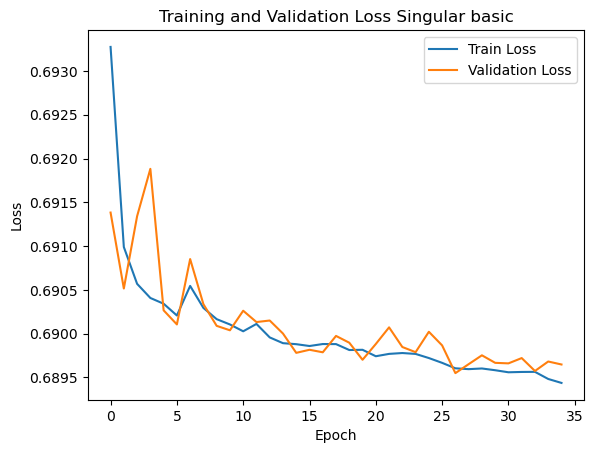

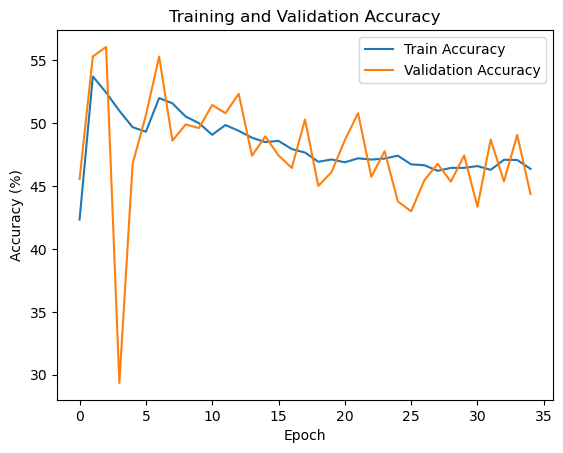

    Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0       1    0.693275       42.336577  0.691383     45.561305
1       2    0.690989       53.724321  0.690515     55.310738
2       3    0.690568       52.442944  0.691341     56.072321
3       4    0.690407       50.990620  0.691882     29.341317
4       5    0.690341       49.687326  0.690266     46.770537
5       6    0.690207       49.327898  0.690104     50.636591
6       7    0.690544       52.006078  0.690851     55.304924
7       8    0.690293       51.583823  0.690336     48.613453
8       9    0.690165       50.530376  0.690088     49.904075
9      10    0.690104       50.010228  0.690037     49.619208
10     11    0.690026       49.082435  0.690261     51.450497
11     12    0.690110       49.859735  0.690131     50.799372
12     13    0.689956       49.396569  0.690149     52.339980
13     14    0.689890       48.850121  0.690000     47.415848
14     15    0.689879       48.497998  0.689780     48.950642
15     1

In [42]:
plt.plot(range(num_epochs_runned), train_losses, label="Train Loss")
plt.plot(range(num_epochs_runned), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Singular basic')
plt.show()

# Plot training and validation accuracy
plt.plot(range(num_epochs_runned), train_accuracies, label="Train Accuracy")
plt.plot(range(num_epochs_runned), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Save the results in a DataFrame for reporting
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_runned + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies
})

print(results_df)